In [ ]:
import torch
import numpy as np
import nugget
from conflictfree.grad_operator import ConFIG_update
import matplotlib.pyplot as plt
import importlib

In [3]:
Skewedgauss = nugget.surrogates.SkewedGaussian.SkewedGaussian()
light_yield_surrogate = Skewedgauss.light_yield_surrogate
signal_sampler = nugget.samplers.toy_sampler.ToySampler(x_bias=0, event_type='signal', domain_size=4)
background_sampler = nugget.samplers.toy_sampler.ToySampler(x_bias=0, event_type='background', domain_size=4)


In [98]:
signal_event = signal_sampler.sample_events(1)
coordinate = signal_sampler.sample_detector_points(1)

In [99]:
coordinate

tensor([[-0.2701,  1.5540, -0.5509]])

In [5]:
light_yield_surrogate(opt_point=coordinate, event_params=signal_event[0])

tensor([0.5975])

In [4]:
importlib.reload(nugget.surrogates.LLRnet)
llr_net = nugget.surrogates.LLRnet.LLRnet(
    domain_size=4,
    dim=3,
    hidden_dims=[256, 128, 64, 32],
    use_fourier_features=True,
    num_parallel_branches=2,
    frequency_scales=[0.1, 0.2],  # Different scales for each branch
    num_frequencies_per_branch=[64,64],
    learnable_frequencies=False,
    dropout_rate=0.1,
    learning_rate=1e-3,
    shared_mlp=False,  # Use shared MLP across branches
    use_residual_connections=True,
    signal_noise_scale=0.05,
    background_noise_scale=0.2,
    add_relative_pos=False
)

In [7]:
train_dataloader = llr_net.create_event_dataloader(signal_sampler = signal_sampler, 
                                                background_sampler = background_sampler,
                                                batch_size=128, 
                                                num_workers=4,
                                                signal_surrogate_func=light_yield_surrogate,
                                                background_surrogate_func=light_yield_surrogate,
                                                num_samples_per_epoch=10000,
                                                event_labels=['position', 'energy', 'zenith', 'azimuth'],
                                                shuffle = False)
val_dataloader = llr_net.create_event_dataloader(signal_sampler = signal_sampler,
                                                background_sampler = background_sampler,
                                                batch_size=32, 
                                                num_workers=2,
                                                signal_surrogate_func=light_yield_surrogate,
                                                background_surrogate_func=light_yield_surrogate,
                                                num_samples_per_epoch=1000,
                                                event_labels=['position', 'energy', 'zenith', 'azimuth'],
                                                shuffle=False)
test_dataloader = llr_net.create_event_dataloader(signal_sampler = signal_sampler,
                                                background_sampler = background_sampler,
                                                batch_size=50, 
                                                num_workers=2,
                                                num_samples_per_epoch=10000,
                                                signal_surrogate_func=light_yield_surrogate,
                                                background_surrogate_func=light_yield_surrogate,
                                                event_labels=['position', 'energy', 'zenith', 'azimuth'],
                                                shuffle = False, output_true_light_yield=True)

In [ ]:
history = llr_net.train_with_dataloader(train_dataloader=train_dataloader,
                                       val_dataloader=val_dataloader,
                                       epochs=800,
                                       early_stopping_patience=50
                                       )
llr_net.save_model('best_toy_model')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Building parallel network architecture:
  Input dim: 10
  Number of parallel branches: 2
  Shared MLP: False
  Branch 0: 64 frequencies, scale 0.100, output dim 128
  Branch 1: 64 frequencies, scale 0.200, output dim 128
  Branch 0 MLP with residual connections: 128 -> [256, 128, 64, 32] -> 32
  Branch 1 MLP with residual connections: 128 -> [256, 128, 64, 32] -> 32
  Final MLP: 64 -> 32 -> 1
  Total trainable parameters: 243,201
Epoch 10/800, Train Loss: 0.6362, Val Loss: 0.6268
Epoch 20/800, Train Loss: 0.5966, Val Loss: 0.5870
Epoch 30/800, Train Loss: 0.5709, Val Loss: 0.5548
Epoch 40/800, Train Loss: 0.5614, Val Loss: 0.5392
Epoch 50/800, Train Loss: 0.5491, Val Loss: 0.5275
Epoch 60/800, Train Loss: 0.5472, Val Loss: 0.5264
Epoch 70/800, Train Loss: 0.5336, Val Loss: 0.5124
Epoch 80/800, Train Loss: 0.5308, Val Loss: 0.4988
Epoch 90/800, Train Loss: 0.5292, Val Loss: 0.5063
Epoch 100/800, Train Loss: 0.5223, Val Loss: 0.4986
Epoch 110/800, Train Loss: 0.5160, Val Loss: 0.4902
Epo

In [5]:
llr_net.load_model('best_toy_model')

Building parallel network architecture:
  Input dim: 10
  Number of parallel branches: 2
  Shared MLP: False
  Branch 0: 64 frequencies, scale 0.100, output dim 128
  Branch 1: 64 frequencies, scale 0.200, output dim 128
  Branch 0 MLP with residual connections: 128 -> [256, 128, 64, 32] -> 32
  Branch 1 MLP with residual connections: 128 -> [256, 128, 64, 32] -> 32
  Final MLP: 64 -> 32 -> 1
  Total trainable parameters: 243,201


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


20000 20000 20000

Evaluation Results:
Accuracy: 0.7726
AUC: 0.8450
Precision: 0.7130
Recall: 0.9127


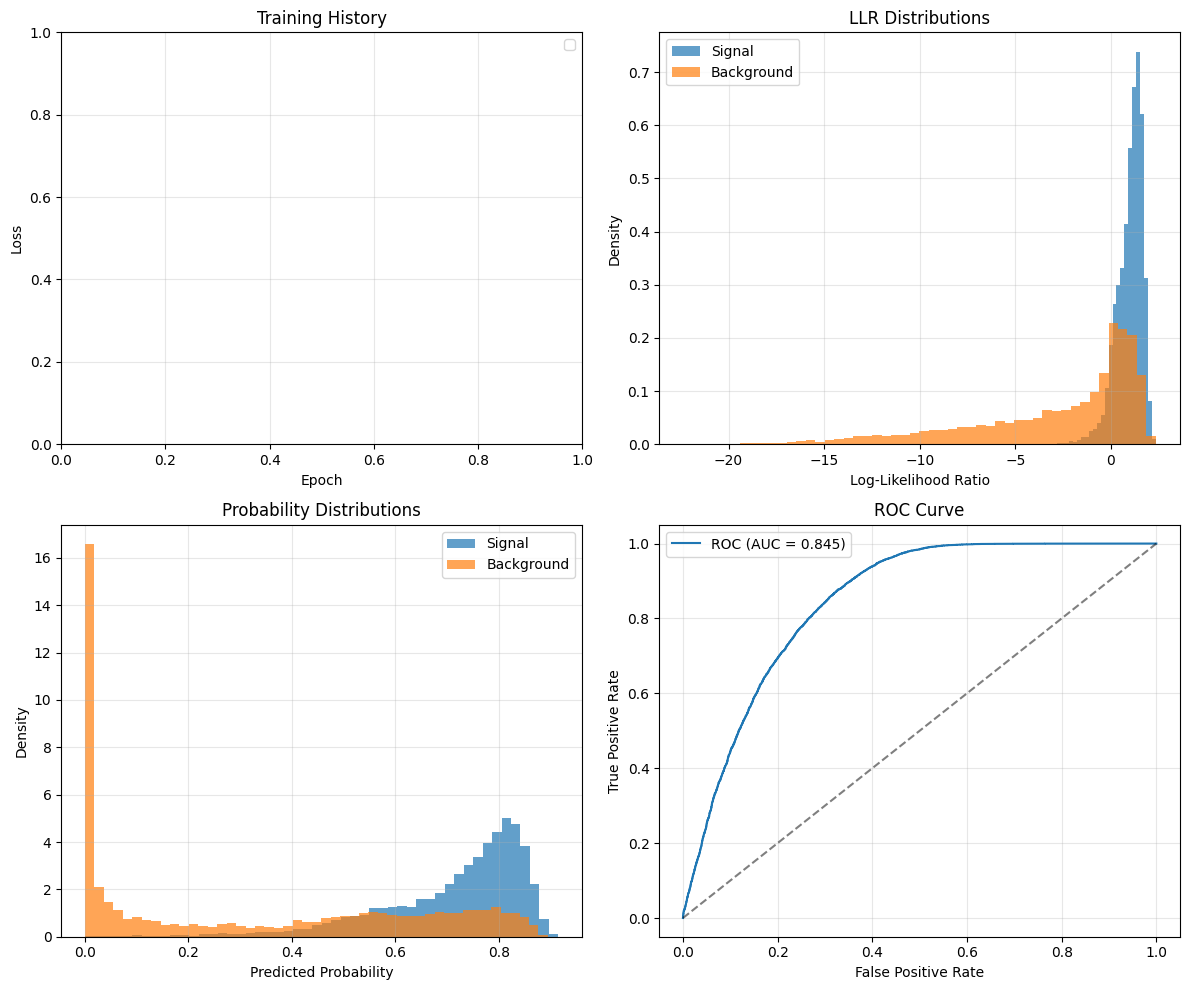

In [ ]:
predictions = []
true_labels = []
llr_values = []
all_features = []
denoised_values = []
with torch.no_grad():
    for features, labels, denoised in test_dataloader:
        # Get LLR predictions
        batch_llr = llr_net.predict_log_likelihood_ratio(features, epsilon=1e-12)
        batch_probs = llr_net.predict_proba(features)
        # print(len(batch_llr), len(batch_probs), len(labels))
        
        llr_values.extend(batch_llr.cpu().numpy())
        predictions.extend(batch_probs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        all_features.extend(features.cpu().numpy())  # Store features for further analysis
        denoised_values.extend(denoised.cpu().numpy())

# Convert to numpy arrays
llr_values = np.array(llr_values)
predictions = np.array(predictions)
true_labels = np.array(true_labels)
all_features = np.array(all_features).squeeze()  # Remove batch dimension if needed
denoised_values = np.array(denoised_values)
print(len(llr_values), len(predictions), len(true_labels))

# Evaluate performance
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

binary_preds = (predictions > 0.5).astype(int)
accuracy = accuracy_score(true_labels, binary_preds)
auc = roc_auc_score(true_labels, predictions)
precision = precision_score(true_labels, binary_preds)
recall = recall_score(true_labels, binary_preds)

print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plot results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Training history
axes[0,0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0,0].plot(history['val_loss'], label='Validation Loss', color='red')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].set_title('Training History')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# LLR distributions
signal_mask = true_labels == 1
background_mask = true_labels == 0

axes[0,1].hist(llr_values[signal_mask], bins=50, alpha=0.7, label='Signal', density=True)
axes[0,1].hist(llr_values[background_mask], bins=50, alpha=0.7, label='Background', density=True)
axes[0,1].set_xlabel('Log-Likelihood Ratio')
axes[0,1].set_ylabel('Density')
axes[0,1].set_title('LLR Distributions')
# axes[0,1].set_xlim(-5, 5)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Probability distributions
axes[1,0].hist(predictions[signal_mask], bins=50, alpha=0.7, label='Signal', density=True)
axes[1,0].hist(predictions[background_mask], bins=50, alpha=0.7, label='Background', density=True)
axes[1,0].set_xlabel('Predicted Probability')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Probability Distributions')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(true_labels, predictions)
axes[1,1].plot(fpr, tpr, label=f'ROC (AUC = {auc:.3f})')
axes[1,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1,1].set_xlabel('False Positive Rate')
axes[1,1].set_ylabel('True Positive Rate')
axes[1,1].set_title('ROC Curve')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/var/folders/40/hq_tym9s6_vcj1qtwjlrl3lw0000gn/T/ipykernel_29523/4130126668.py:12: RuntimeWarning: invalid value encountered in divide
  llr_density = np.log(binned_sig/binned_bg)
/var/folders/40/hq_tym9s6_vcj1qtwjlrl3lw0000gn/T/ipykernel_29523/4130126668.py:12: RuntimeWarning: divide by zero encountered in log
  llr_density = np.log(binned_sig/binned_bg)


(-8.561873435974121, 2.6948399543762207)

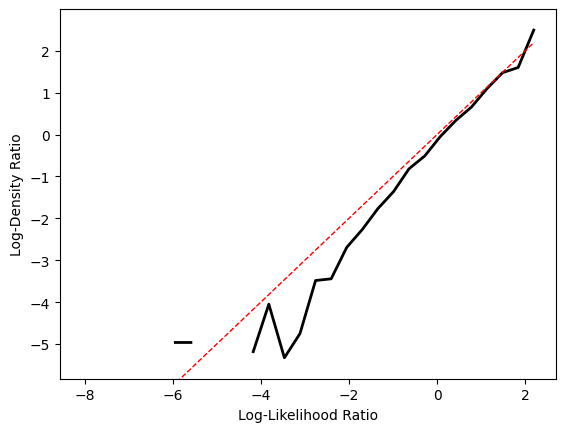

In [11]:
bg_mask = (true_labels == 0) 
sig_mask = (true_labels == 1) 
binned_bg, bins = np.histogram(llr_values[bg_mask], bins=70, range=(min(llr_values), max(llr_values)), density=True)
binned_sig, bins= np.histogram(llr_values[sig_mask], bins=70, range=(min(llr_values), max(llr_values)), density=True)
f_vals = (bins[:-1] + bins[1:]) / 2  # Midpoints of bins
# print(f"bin centers: {f_vals}")
# kde_b = gaussian_kde(nn_log_ratios[bg_mask])
# kde_s = gaussian_kde(nn_log_ratios[sig_mask])

# f_vals = np.linspace(-7, 7, 1000)
# llr_density = np.log(kde_s(f_vals) / kde_b(f_vals))
llr_density = np.log(binned_sig/binned_bg)  
# print(f'llr density: {llr_density}')
plt.plot(f_vals, llr_density, 'k-', linewidth=2, label='LLR Density')
plt.plot(f_vals, f_vals, 'r--', linewidth=1)
plt.xlabel('Log-Likelihood Ratio')
plt.ylabel('Log-Density Ratio')
plt.ylim(min(llr_density[~np.isinf(np.abs(llr_density)) & ~np.isnan(llr_density)])-0.5, max(llr_density[~np.isinf(np.abs(llr_density)) & ~np.isnan(llr_density)])+0.5)
plt.xlim(min(f_vals[~np.isinf(np.abs(llr_density)) & ~np.isnan(llr_density)])-0.5, max(f_vals[~np.isinf(np.abs(llr_density)) & ~np.isnan(llr_density)])+0.5)
# plt.xlim(-0.2,1.75)
# plt.ylim(-0.2,1.75)

/var/folders/40/hq_tym9s6_vcj1qtwjlrl3lw0000gn/T/ipykernel_29523/398876921.py:50: RuntimeWarning: Mean of empty slice.
  bin_means = [signal_llr[digitized == i].mean() for i in range(1, len(bins))]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.d

(-4.0, 3.5)

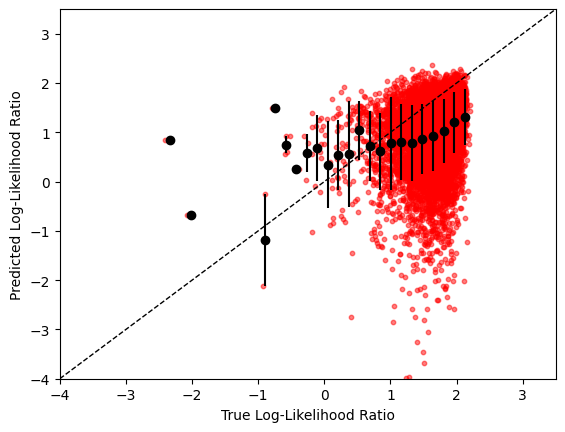

In [12]:
def true_log_likelihood(noisy_light_yield, denoised_light_yield, energy, E_power_law = 2.7, E_min = 0.8, E_max =1, noise_scale=0.05, zenith=None, a=None):
    energy_ll = np.log((1- E_power_law)* energy**(-E_power_law) / (E_max**(1-E_power_law) - E_min**(1-E_power_law)))
    noise_ll = -0.5 * (np.log(2 * np.pi) + np.log((denoised_light_yield*noise_scale)**2) + ((denoised_light_yield - noisy_light_yield)**2 / ((denoised_light_yield*noise_scale)**2)))
    full_ll = energy_ll + noise_ll
    if zenith is not None and a is not None:
        pos_ll = np.log((1 + a * (1-np.abs(np.cos(zenith))))/(2+a))
        full_ll += pos_ll
    return full_ll

def marginalize_log_likelihood(pos, light_yield, noisy_light_yield, sampler, num_samples=100, noise_scale=0.2, 
                               surrogate_func=None, E_power_law=3.7, E_min=0.8, E_max=1,  a = 1.5):

    # Sample background events
    event_params = sampler.sample_events(num_samples)
   
    log_likelihoods = []
    for param in event_params:
        # light_yield = surrogate_func(opt_point=pos, event_params=param)
        
        # noisy_light_yield = (np.random.normal(0, noise_scale)*light_yield + light_yield)
        
        energy = param.get('energy')
        zenith = param.get('zenith')
        ll = true_log_likelihood(noisy_light_yield, light_yield, energy, zenith=zenith, a=a, E_power_law=E_power_law, E_min=E_min, E_max=E_max, noise_scale=noise_scale)
        log_likelihoods.append(ll)
    log_likelihoods = np.array(log_likelihoods)
    # Compute log-likelihoods


    # Marginalize over background events
    return  np.log(np.sum(np.exp(log_likelihoods))) - np.log(num_samples)

signal_llr = llr_values[sig_mask].squeeze()
signal_ly = all_features[sig_mask][:,-1].squeeze()
signal_pos = all_features[sig_mask][:,:3]
signal_energy = all_features[sig_mask][:,-4].squeeze()
signal_denoised_ly = denoised_values[sig_mask].squeeze()
signal_true_signal_ll = true_log_likelihood(signal_ly, signal_denoised_ly, signal_energy).squeeze()
signal_true_background_ll = []
for i, pos in enumerate(signal_pos):
    pos = torch.tensor(pos).float().unsqueeze(0)
    signal_true_background_ll.append(marginalize_log_likelihood(pos, signal_ly[i], signal_denoised_ly[i], background_sampler, num_samples=100, surrogate_func=light_yield_surrogate).squeeze())
signal_true_background_ll = np.array(signal_true_background_ll).squeeze()
#plot true vs predicted LLR for signal events
plt.scatter(signal_true_signal_ll/signal_true_background_ll, signal_llr, alpha=0.5, s=10, color='red')
#bin the points and plot the mean and std in each bin
bins = np.linspace(min(signal_true_signal_ll/signal_true_background_ll), max(signal_true_signal_ll/signal_true_background_ll), 30)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
digitized = np.digitize(signal_true_signal_ll/signal_true_background_ll, bins)
bin_means = [signal_llr[digitized == i].mean() for i in range(1, len(bins))]
bin_stds = [signal_llr[digitized == i].std() for i in range(1, len(bins))]
bin_means = np.array(bin_means)
bin_stds = np.array(bin_stds)
plt.errorbar(bin_centers[~np.isnan(bin_stds)], bin_means[~np.isnan(bin_stds)], yerr=bin_stds[~np.isnan(bin_stds)], fmt='o', color='k')

# bkg_llr = llr_values[bg_mask].squeeze()
# bkg_ly = all_features[bg_mask][:,-1].squeeze()
# bkg_pos = all_features[bg_mask][:,:3]
# bkg_energy = all_features[bg_mask][:,-4].squeeze()
# bkg_denoised_ly = denoised_values[bg_mask].squeeze()
# bkg_true_signal_ll = true_log_likelihood(bkg_ly, bkg_denoised_ly, bkg_energy).squeeze()
# bkg_true_background_ll = []
# for i, pos in enumerate(bkg_pos):
#     pos = torch.tensor(pos).float().unsqueeze(0)
#     bkg_true_background_ll.append(marginalize_log_likelihood(pos, bkg_ly[i], bkg_denoised_ly[i], background_sampler, num_samples=100, surrogate_func=light_yield_surrogate).squeeze())
# bkg_true_background_ll = np.array(bkg_true_background_ll).squeeze()
# #plot true vs predicted LLR for signal events
# plt.scatter(bkg_true_signal_ll/bkg_true_background_ll, bkg_llr, alpha=0.5, s=10, color='blue')
# #bin the points and plot the mean and std in each bin
# bins = np.linspace(min(bkg_true_signal_ll/bkg_true_background_ll), max(bkg_true_signal_ll/bkg_true_background_ll), 10)
# bin_centers = 0.5 * (bins[:-1] + bins[1:])
# digitized = np.digitize(bkg_true_signal_ll/bkg_true_background_ll, bins)
# bin_means = [bkg_llr[digitized == i].mean() for i in range(1, len(bins))]
# bin_stds = [bkg_llr[digitized == i].std() for i in range(1, len(bins))]
# bin_means = np.array(bin_means)
# bin_stds = np.array(bin_stds)
# plt.errorbar(bin_centers[~np.isnan(bin_stds)], bin_means[~np.isnan(bin_stds)], yerr=bin_stds[~np.isnan(bin_stds)], fmt='o', color='green')
plt.xlabel('True Log-Likelihood Ratio')
plt.ylabel('Predicted Log-Likelihood Ratio')
plt.plot([-4, 4], [-4, 4], 'k--', linewidth=1)
plt.xlim(-4,3.5)
plt.ylim(-4,3.5)

In [14]:
new_signal_events = signal_sampler.sample_events(250)
new_background_events = background_sampler.sample_events(250)

In [52]:
geometry = nugget.geometries.EvanescentString.EvanescentString(
        domain_size=4,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        dim=3,
        n_strings=1000,
        points_per_string=5,
        starting_weight=0.3,
        )

In [53]:
# importlib.reload(nugget.utils.vis_tools)
visualizer = nugget.utils.vis_tools.Visualizer(
                                device=geometry.device,
                                dim=geometry.dim, 
                                domain_size=geometry.domain_size,
                                gif_temp_dir='gif_temp',
                            
        )
optimizer = nugget.utils.basic_optimizer.Optimizer(
                        device=geometry.device, 
                        geometry=geometry,
                        visualizer=visualizer,
                        conflict_free=False,
                        use_custom_cf_weight=False,
                        )
optimizer.init_geometry(opt_list=[('string_weights',0.1)])

Optimizing string_weights with torch.Size([1000]) shape


In [17]:
string_xy = optimizer.geom_dict['string_xy']
dists = np.linalg.norm(string_xy[:, None, :] - string_xy[None, :, :], axis=-1)
print(min(dists[dists > 0]))  # Minimum distance between strings

0.11111033


In [54]:
signal_llr_loss_func = nugget.losses.LLR.WeightedLLRLoss(
                    device=geometry.device,
                    llr_net=llr_net,
                    no_grad=True
                    )
background_llr_loss_func = nugget.losses.LLR.WeightedLLRLoss(
                    device=geometry.device,
                    llr_net=llr_net,
                    no_grad=True
                    )
signal_yield_loss_func = nugget.losses.light_yield.WeightedLightYieldLoss(
                            device=geometry.device,
                                )
fisher_info_loss_func = nugget.losses.fisher_info.WeightedFisherInfoLoss(
    device=geometry.device,
        )
weighted_dif_llr_loss = nugget.losses.LLR.WeightedMeanDifLLRLoss(
    llr_net=llr_net,
    no_grad=True,
    device=geometry.device)

local_string_repulsion_penalty = nugget.losses.geometry_penalties.LocalStringRepulsionPenalty(
    device=geometry.device)

string_boundary_penalty = nugget.losses.geometry_penalties.StringBoundaryPenalty(
    device=geometry.device,)

string_repulsion_penalty = nugget.losses.geometry_penalties.StringRepulsionPenalty(
    device=geometry.device)

string_weights_penalty = nugget.losses.geometry_penalties.StringWeightsPenalty(
    device=geometry.device)

string_number_penalty = nugget.losses.geometry_penalties.StringNumberPenalty(
    device=geometry.device)

weighted_binarization_penalty = nugget.losses.geometry_penalties.WeightBinarizationPenalty(
    device=geometry.device)

weighted_angular_resolution_loss = nugget.losses.fisher_info.WeightedResolutionLoss(
    device=geometry.device,
    resolution_type='angular'
)
weighted_energy_resolution_loss = nugget.losses.fisher_info.WeightedResolutionLoss(
    device=geometry.device,
    resolution_type='energy'
)

rov_penalty = nugget.losses.geometry_penalties.ROVPenalty(
    device=geometry.device, rov_rec_width=0.4, rov_height=0.24, rov_tri_length=0.12)

loss_params = {
    'llr_net': llr_net,
    'signal_event_params': new_signal_events,   
    'background_event_params': new_background_events,
    'signal_surrogate_func': light_yield_surrogate,
    'background_surrogate_func': light_yield_surrogate,
    'signal_sampler': signal_sampler,
    'background_sampler': background_sampler,
    'num_events': 50,
    'signal_noise_scale': 0.05,
    'background_noise_scale': 0.2,
    'boundary_range': 2
}

loss_params.update({
    'eva_min_num_strings': 70,
    'max_radius': 0.12
})
loss_func_dict = {
                'angular_resolution_loss': weighted_angular_resolution_loss,
                'energy_resolution_loss': weighted_energy_resolution_loss,
                'fisher_loss': fisher_info_loss_func, 
                'signal_yield_loss': signal_yield_loss_func,
                'signal_llr_loss': signal_llr_loss_func,
                'local_string_repulsion_penalty': local_string_repulsion_penalty,
                # 'string_repulsion_penalty': string_repulsion_penalty,
                'string_weights_penalty': string_weights_penalty,
                'string_number_penalty': string_number_penalty,
                'rov_penalty': rov_penalty,
                'string_boundary_penalty': string_boundary_penalty,
            #   'weight_binarization_penalty': weighted_binarization_penalty
                }

loss_weights_dict = {
                'angular_resolution_loss': 0,
                'energy_resolution_loss': 0,
                'fisher_loss': 1e3, 
                'signal_yield_loss': 1e3,
                'signal_llr_loss': 0.5,
                'string_boundary_penalty': 10000,
                'local_string_repulsion_penalty': 1,
                'string_repulsion_penalty': 0.000001,
                'string_weights_penalty': 10,
                'string_number_penalty': 0.2,
                'weight_binarization_penalty': 0.01,
                'rov_penalty': 1
                }

cf_loss_weights_dict = {
                'fisher_loss': 0.01, 
                'signal_yield_loss': 0.0005,
                'signal_llr_loss': 0.001,
                'local_string_repulsion_penalty': 10000,
                'string_repulsion_penalty': 1,
                'string_weights_penalty': 50,
                'string_number_penalty': 5000,
                'weight_binarization_penalty': 0.01,
                'string_boundary_penalty': 10000,
                'rov_penalty': 10000
                }

plot_types = [
            'loss_components',
            'uw_loss_components', 
            # 'llr_histogram', 
            'string_weights_scatter',
            'signal_llr_contour', 
            # 'background_llr_contour', 
            'signal_light_yield_contour',
            'fisher_info_logdet',
            'angular_resolution',
            'energy_resolution',
            ]
vis_kwargs = {
            'plot_types':plot_types,
            'slice_res':50,
            'multi_slice':True,
            'gif_plot_selection': plot_types,
            'loss_filter': ['string_boundary_penalty', 'string_number_penalty', ],
            }

In [ ]:
precomputed_signal_llr_per_string = signal_llr_loss_func.compute_LLR_per_string(
                            string_xy=optimizer.geom_dict['string_xy'],
                            points_3d=optimizer.geom_dict['points_3d'],
                            event_params=new_signal_events,
                            surrogate_func=light_yield_surrogate
                                )

In [149]:
precomputed_signal_yield_per_string = signal_yield_loss_func.light_yield_per_string(
                            string_xy=optimizer.geom_dict['string_xy'],
                            points_3d=optimizer.geom_dict['points_3d'],
                            event_params=new_signal_events,
                            surrogate_func=light_yield_surrogate
                                )

In [164]:
precomputed_fisher_info_per_string = fisher_info_loss_func.compute_fisher_info_per_string(
                            string_xy=optimizer.geom_dict['string_xy'],
                            points_3d=optimizer.geom_dict['points_3d'],
                            signal_event_params=new_signal_events,
                            signal_surrogate_func=light_yield_surrogate,
                            # llr_net=llr_net, signal_noise_scale=0.05, llr_iterations=100, add_relative_pos=False
                                )

In [28]:
precomputed_fisher_info_per_string_per_event = weighted_angular_resolution_loss.compute_fisher_info_per_string_per_event(
                            string_xy=optimizer.geom_dict['string_xy'],
                            points_3d=optimizer.geom_dict['points_3d'],
                            signal_event_params=new_signal_events,
                            signal_surrogate_func=light_yield_surrogate,
                            )

In [ ]:
torch.save(precomputed_fisher_info_per_string, './precomputed_fisher_info_per_string_ly.pt')
torch.save(precomputed_signal_yield_per_string, './precomputed_signal_yield_per_string.pt')
torch.save(precomputed_signal_llr_per_string, './precomputed_signal_llr_per_string.pt')
torch.save(precomputed_fisher_info_per_string_per_event, './precomputed_fisher_info_per_string_per_event_ly.pt')

In [20]:
precomputed_fisher_info_per_string = torch.load('./precomputed_fisher_info_per_string_ly.pt')
precomputed_signal_yield_per_string = torch.load('./precomputed_signal_yield_per_string.pt')
precomputed_signal_llr_per_string = torch.load('./precomputed_signal_llr_per_string.pt')

In [55]:
loss_params.update({
    'precomputed_signal_llr_per_string': precomputed_signal_llr_per_string,
    'precomputed_signal_yield_per_string': precomputed_signal_yield_per_string,
    'precomputed_fisher_info_per_string': precomputed_fisher_info_per_string,
    'precomputed_fisher_info_per_string_per_event': precomputed_fisher_info_per_string_per_event
})

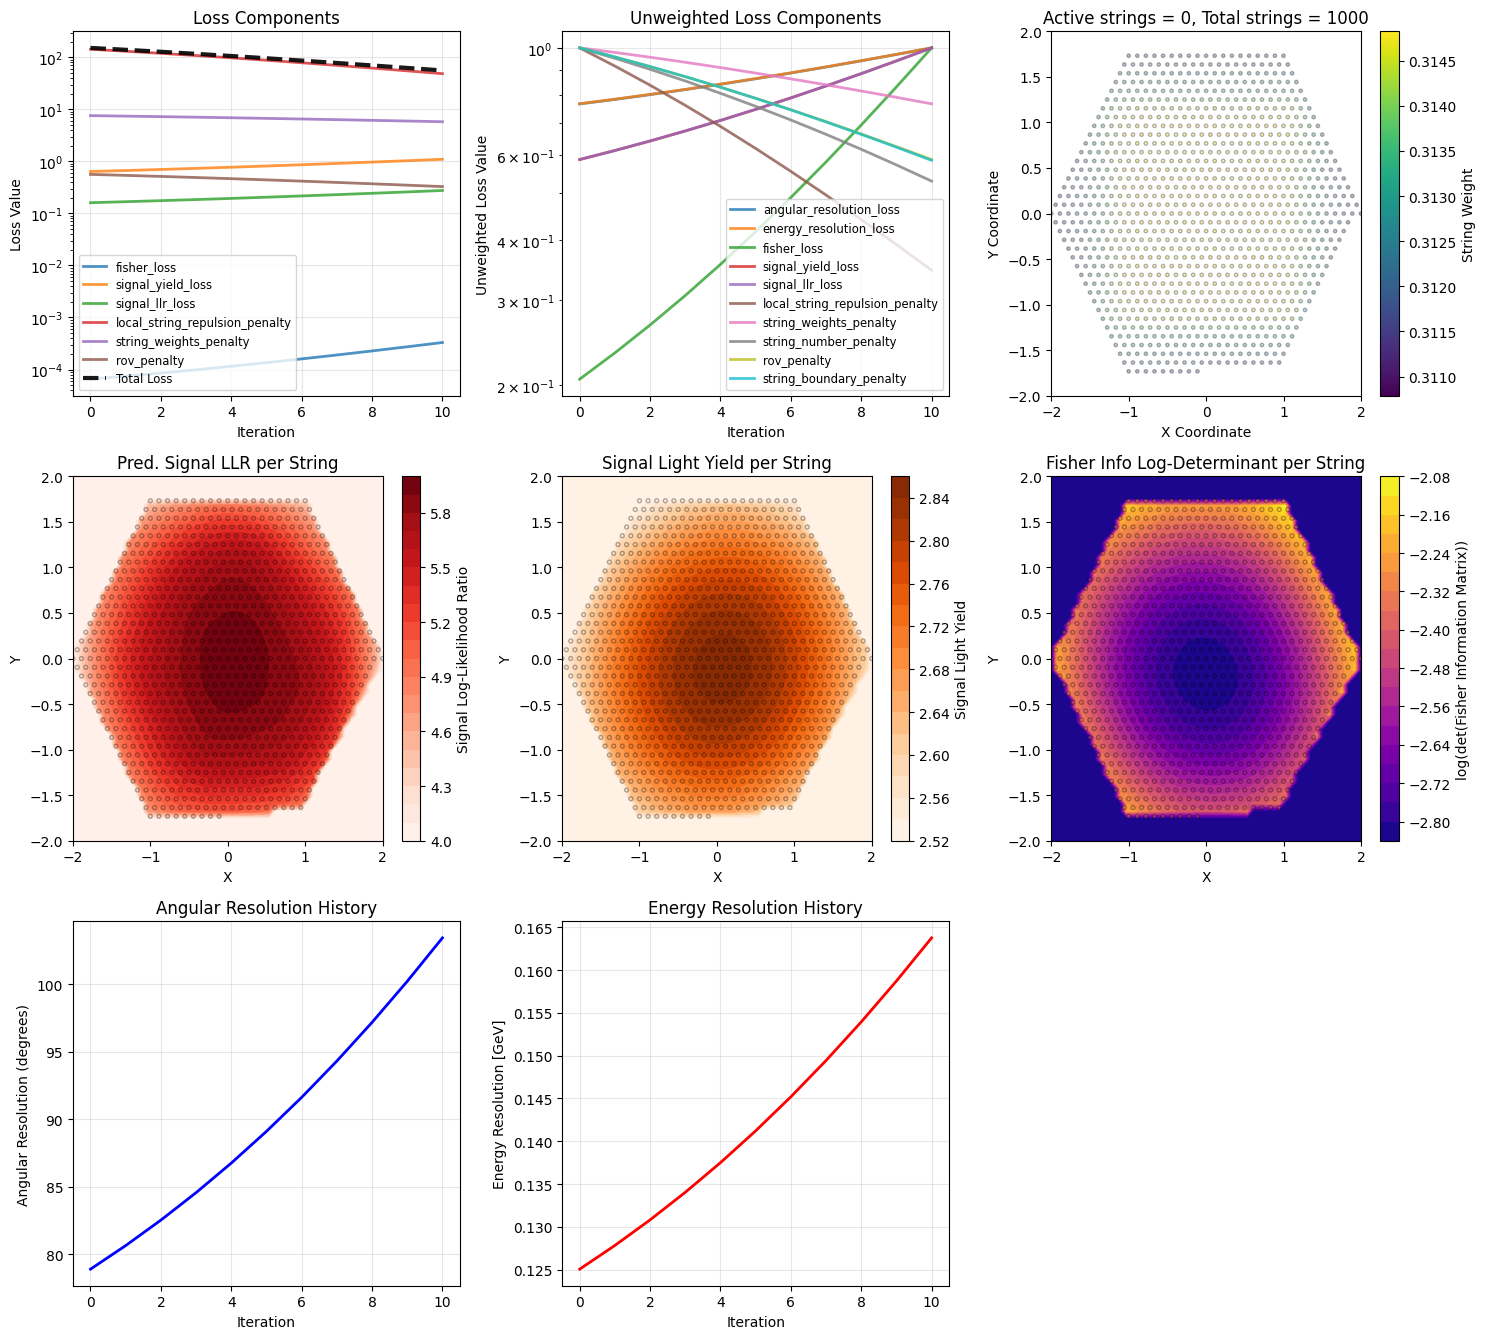

Saved GIF frame 3 to gif_temp/frame_0017.png
Iter 16/600, Total Loss: 356.7857 |  |  | fisher_loss: 0.0009 | signal_yield_loss: 1.5236 | signal_llr_loss: 0.3830 | local_string_repulsion_penalty: 25.1914 | string_weights_penalty: 4.9094 | string_number_penalty: 34.2063 | rov_penalty: 0.2363 | string_boundary_penalty: 290.3349
Saved GIF frame 4 to gif_temp/frame_0033.png


In [ ]:
# optimizer.visualizer.cleanup_gif_temp_files()
geom_dict = optimizer.optimize(
    loss_func_dict=loss_func_dict,
    loss_weights_dict=loss_weights_dict,
    loss_params_dict=loss_params,
    n_iter=600,
    vis_kwargs=vis_kwargs,
    print_freq=5,
    vis_freq=10,
    gif_freq=5,
    # cf_loss_weights_dict=cf_loss_weights_dict,
    # loss_dict=optimizer.loss_dict,
    # uw_loss_dict=optimizer.uw_loss_dict,
    # vis_loss_dict=optimizer.vis_loss_dict,
    # vis_uw_loss_dict=optimizer.vis_uw_loss_dict  
)

In [192]:
optimizer.visualizer.finalize_gif(
    gif_filename='../gifs/opt_test_no_cf_boundary_fi.gif',
    gif_fps=10,
    cleanup_images=False)

Successfully compiled GIF '../gifs/opt_test_no_cf_boundary_fi.gif' with 81 frames.


True

In [ ]:
optimizer.visualizer.create_interactive_3d_plot(
    points_3d=optimizer.geom_dict['points_3d'],
    string_xy=optimizer.geom_dict['string_xy'],
    string_weights=optimizer.geom_dict['string_weights'],
    weight_threshold=0.7,
    points_per_string_list=optimizer.geom_dict['points_per_string_list']
    )

In [ ]:
new_geometry = nugget.geometries.DynamicString.DynamicString(
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        )

In [35]:
visualizer = nugget.utils.vis_tools.Visualizer(
                                device=new_geometry.device,
                                dim=new_geometry.dim, 
                                domain_size=new_geometry.domain_size,
                                gif_temp_dir='gif_temp'
        )
optimizer = nugget.utils.basic_optimizer.Optimizer(
                        device=new_geometry.device, 
                        geometry=new_geometry,
                        visualizer=visualizer,
                        conflict_free=False
                        )
optimizer.init_geometry(opt_list=[('string_xy',0.01),('z_values',0.01)], geom_dict=geom_dict)

Using pre-trained dynamic string geometry as starting point
Filtering strings: 63 out of 500 strings active
Filtered string_xy to 63 strings
Filtered z_values from 2500 to 315 points
Created per-point string_indices for active strings, total_points now: 315
Optimizing string_xy with torch.Size([63, 2]) shape
Optimizing z_values with torch.Size([315]) shape


In [ ]:
signal_llr_loss_func = nugget.losses.LLR.LLRLoss(
                    device=geometry.device,
                    llr_net=llr_net,
                    )
background_llr_loss_func = nugget.losses.LLR.LLRLoss(
                    device=geometry.device,
                    llr_net=llr_net,
                    )
signal_yield_loss_func = nugget.losses.light_yield.LightYieldLoss(
                            device=geometry.device,
                                )
fisher_info_loss_func = nugget.losses.fisher_info.FisherInfoLoss(
    device=geometry.device,
        )
dif_llr_loss = nugget.losses.LLR.MeanDifLLRLoss(
    llr_net=llr_net,
    device=geometry.device)

string_repulsion_penalty = nugget.losses.geometry_penalties.StringRepulsionPenalty(
    device=geometry.device)

local_string_repulsion_penalty = nugget.losses.geometry_penalties.LocalStringRepulsionPenalty(
    device=geometry.device)

z_distance_repulsion_penalty = nugget.losses.geometry_penalties.ZDistRepulsionPenalty(
    device=geometry.device)

boundary_penalty = nugget.losses.geometry_penalties.BoundaryPenalty(
    device=geometry.device)



loss_params = {
    'llr_net': llr_net,
    # 'signal_event_params': new_signal_events,   
    # 'background_event_params': new_background_events,
    'signal_surrogate_func': light_yield_surrogate,
    'background_surrogate_func': light_yield_surrogate,
    'signal_sampler': signal_sampler,
    'background_sampler': background_sampler,
    'num_events': 50,
    'signal_noise_scale': 0.05,
    'background_noise_scale': 0.2
}

loss_params.update({
    'domain_size': 2,
    'max_radius': 0.08
})
loss_func_dict = {
                # 'fisher_loss': fisher_info_loss_func, 
                'signal_yield_loss': signal_yield_loss_func,
                'signal_llr_loss': signal_llr_loss_func,
                'mean_dif_llr_loss': dif_llr_loss,
                # 'string_repulsion_penalty': string_repulsion_penalty,
                'local_string_repulsion_penalty': local_string_repulsion_penalty,
                'z_dist_repulsion_penalty': z_distance_repulsion_penalty,
                'boundary_penalty': boundary_penalty
                }

loss_weights_dict = {
                # 'fisher_loss': 1e4, 
                # 'signal_yield_loss': 5e2,
                'signal_llr_loss': 100,
                'mean_dif_llr_loss': 1,
                'string_repulsion_penalty': 0.01,
                'local_string_repulsion_penalty': 0.1,
                'z_distance_repulsion_penalty': 0.0001,
                'boundary_penalty': 0.01
            #   'weight_binarization_penalty': 0.01
                }

plot_types = [
            'loss_components', 
            '3d_points',
            'llr_histogram_points', 
            # 'xy_projection',
            'signal_llr_contour_points', 
            'background_llr_contour_points',
            'signal_light_yield_contour_points',
            # 'fisher_info_logdet'
            ]
vis_kwargs = {
            'plot_types':plot_types,
            'slice_res':50,
            'multi_slice':True,
            'gif_plot_selection': plot_types
            }

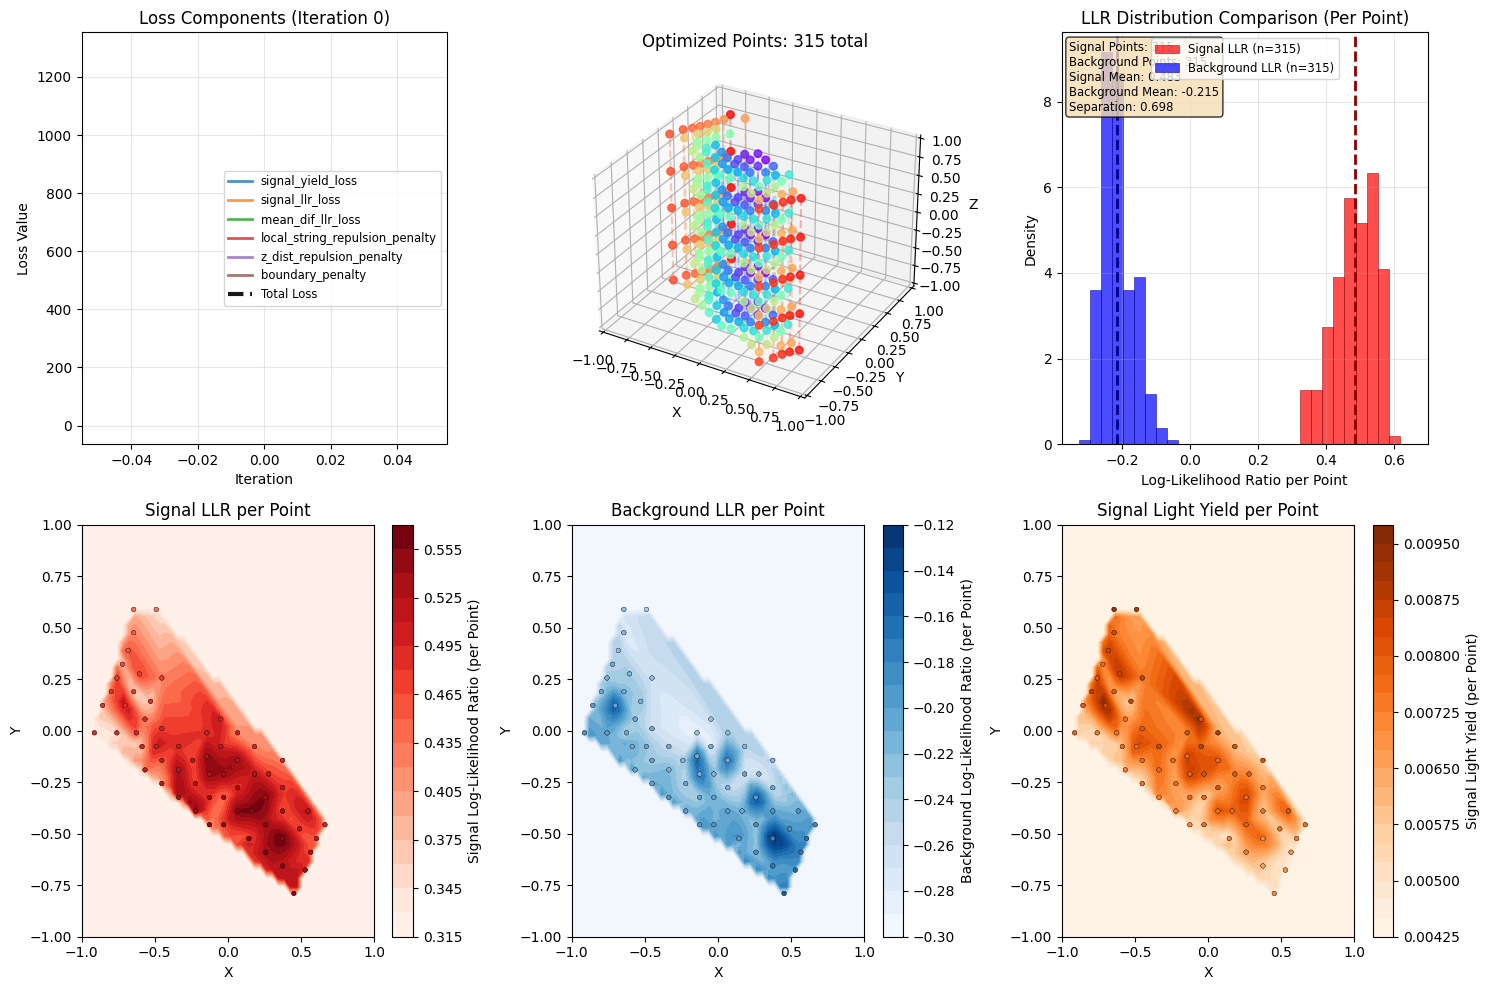

Saved GIF frame 1 to gif_temp/frame_0001.png
Iter 6/400, Total Loss: 1206.8055 | signal_yield_loss: 10.2275 | signal_llr_loss: 0.6109 | mean_dif_llr_loss: 2.5692 | local_string_repulsion_penalty: 3.0259 | z_dist_repulsion_penalty: 1190.3721 | boundary_penalty: 0.0000
Saved GIF frame 2 to gif_temp/frame_0007.png
Iter 11/400, Total Loss: 1164.0044 | signal_yield_loss: 10.9622 | signal_llr_loss: 1.3433 | mean_dif_llr_loss: 3.6456 | local_string_repulsion_penalty: 2.3679 | z_dist_repulsion_penalty: 1145.6853 | boundary_penalty: 0.0000
Saved GIF frame 3 to gif_temp/frame_0018.png


In [ ]:
new_geom_dict = optimizer.optimize(
    loss_func_dict=loss_func_dict,
    loss_weights_dict=loss_weights_dict,
    loss_params_dict=loss_params,
    n_iter=400,
    vis_kwargs=vis_kwargs,
    print_freq=5,
    vis_freq=20,
    gif_freq=5,
    alternate_freq=10 
)